<img src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 20%; margin-right: 15%; margin-left: 15%; margin-bottom: 2.0em;">
<img src="https://spark.apache.org/images/spark-logo-trademark.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 15%; margin-bottom: 2.0em;">
<p style="clear: both;">
<div style="text-align:center"><h1>Handwritten Digit Classification using Deep Feed Forward Neural Network</h1></div>
<div style="text-align:center"><h2><i>Using Apache Spark and Intel BigDL</i></h2></div>
<hr style="border-top-width: 4px; border-top-color: #34609b;">

#  Handwritten Digit Classification using Deep Feed Forward Neural Network Using Spark and BigDL
***Author: Riccardo Castellotti***_  
***Contact: Riccardo Castellotti / Luca Canali / Prasanth Kothuri***  
  
To run this notebook we used the following configuration:
* *Software stack*: LCG 94 (it has spark 2.3.1)
* *Platform*: centos7-gcc7
* *Spark cluster*: Analytix

The tutorial presented will tackle the MNIST digit classification problem. We will build a deep feed forward neural network to help us solve the problem, which is actually a Multilayer Perceptron with two hidden layers. In a feed forward network information always moves one direction instead of ever going backwards, i.e. it has no loop or cycle inside. It's the simplest type of neural networks so it's easy and great to start with to be familiar with how to use BigDL to unleash its power.  
  
Link to Intel BigDL framework - https://bigdl-project.github.io/0.7.0/

In [1]:
sc.addPyFile("/eos/project/s/swan/public/BigDL/bigdl-0.7.0-python-api.zip")

In [2]:
from __future__ import print_function
import matplotlib
import pandas
import numpy as np
import datetime as dt
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.util import common
from bigdl.dataset.transformer import *
from bigdl.dataset import mnist
import matplotlib.pyplot as plt
from pyspark import SparkContext
from matplotlib.pyplot import imshow

/tmp/spark-f9321949-7729-4507-9930-2e5642682f77/userFiles-ebfa5df3-2d3e-47a1-8b1d-cfcf8324de47/bigdl-0.7.0-python-api.zip/bigdl/util/engine.py:41: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /cvmfs/sft.cern.ch/lcg/releases/spark/2.3.1-e21e3/x86_64-centos7-gcc7-opt, and pyspark is found in: /cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.


In [3]:
init_engine()

## 1. Load MNIST dataset
First, we should get and store MNIST into RDD of Sample.
Note: *edit the \"mnist_path\" accordingly. If the \"mnist_path\" directory does not consist of the mnist data, mnist.read_data_sets method will download the dataset directly to the directory*

In [4]:
def get_mnist(sc, mnist_path):
    # target is start from 0,
    (train_images, train_labels) = mnist.read_data_sets(mnist_path, "train")
    (test_images, test_labels) = mnist.read_data_sets(mnist_path, "test")
    training_mean = np.mean(train_images)
    training_std = np.std(train_images)
    rdd_train_images = sc.parallelize(train_images)
    rdd_train_labels = sc.parallelize(train_labels)
    rdd_test_images = sc.parallelize(test_images)
    rdd_test_labels = sc.parallelize(test_labels)

    rdd_train_sample = rdd_train_images.zip(rdd_train_labels).map(lambda features_label:
                                        common.Sample.from_ndarray(
                                        (features_label[0] - training_mean) / training_std,
                                        features_label[1] + 1))
    rdd_test_sample = rdd_test_images.zip(rdd_test_labels).map(lambda features_label1:
                                        common.Sample.from_ndarray(
                                        (features_label1[0] - training_mean) / training_std,
                                        features_label1[1] + 1))
    return (rdd_train_sample, rdd_test_sample)


In [5]:
mnist_path = "datasets/mnist"
(train_data, test_data) = get_mnist(sc, mnist_path)
print(train_data.count())
print(test_data.count())

('Extracting', 'datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


## 2. Hyperparameter setup
NOTE: the `batch_size` variable has to be divisible by the number of cores available (for BigDL to be able to distribute the workload). If you change the configuration of the SparkSession, you also need to change the `batch_size` value. 

In [6]:
learning_rate = 0.2
training_epochs = 15
batch_size = 2048
display_step = 1
# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

## 3. Model creation
Let's define our multilayer_perceptron(MLP) model with 2 hidden layers here.

In [7]:
def multilayer_perceptron(n_hidden_1, n_hidden_2, n_input, n_classes):
# Initialize a sequential container
    model = Sequential()
    # Hidden layer with ReLu activation
    model.add(Reshape([28*28]))
    model.add(Linear(n_input, n_hidden_1).set_name('mlp_fc1'))
    model.add(ReLU())
    # Hidden layer with ReLu activation
    model.add(Linear(n_hidden_1, n_hidden_2).set_name('mlp_fc2'))
    model.add(ReLU())
    # output layer
    model.add(Linear(n_hidden_2, n_classes).set_name('mlp_fc3'))
    model.add(LogSoftMax())
    return model

model = multilayer_perceptron(n_hidden_1, n_hidden_2, n_input, n_classes)

creating: createSequential
creating: createReshape
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createLogSoftMax


## 4. Optimizer setup and training
Let's create an optimizer for training. As presented in the code, we are trying to optimize a [ClassNLLCriterion](https://bigdl-project.github.io/master/#APIGuide/Losses/#classnllcriterion) and use Stochastic Gradient Descent to update the weights. Also in order to enable visualization support, we need to [generate summary info in BigDL](https://bigdl-project.github.io/master/#ProgrammingGuide/visualization/

In [8]:
optimizer = Optimizer(
model=model,
training_rdd=train_data,
criterion=ClassNLLCriterion(),
optim_method=SGD(learningrate=learning_rate),
end_trigger=MaxEpoch(training_epochs),
batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
batch_size=batch_size,
val_rdd=test_data,
trigger=EveryEpoch(),
val_method=[Top1Accuracy()]
)

app_name='multilayer_perceptron-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
 app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ",app_name)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  multilayer_perceptron-20181206-201037


In [9]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")


Optimization Done.
CPU times: user 22.5 s, sys: 11.4 s, total: 33.9 s
Wall time: 2min 36s


## 5. Loss visualization

"After training, we can draw the preformance curves from the previous `train_summary` and `val_summary` variables."

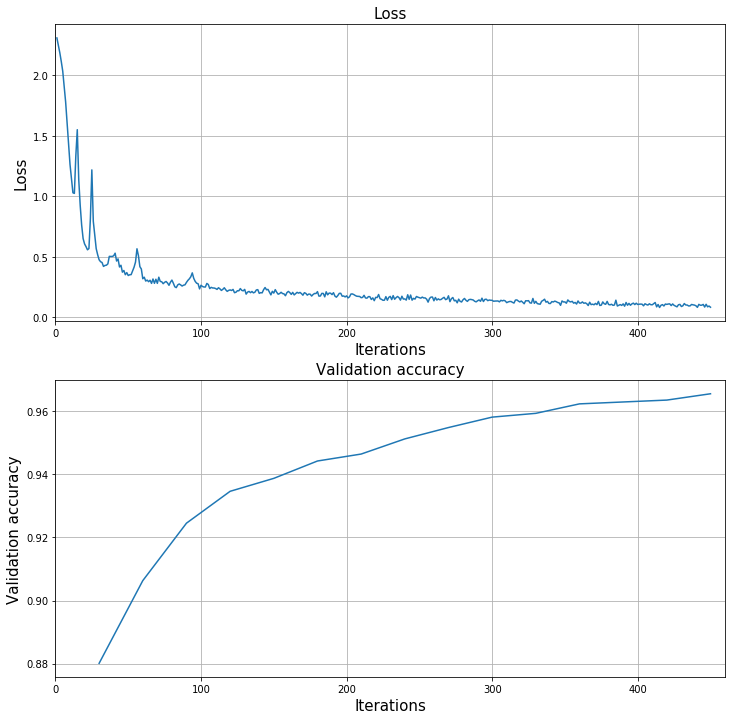

In [10]:
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))

ax=plt.subplot(2,1,1)
ax.plot(loss[:,0],loss[:,1])
plt.xlim(0,loss.shape[0]+10)
ax.grid(True)
ax.set_xlabel("Iterations",fontSize=15)
ax.set_ylabel("Loss",fontSize=15)
plt.title("Loss",fontSize=15)

ax=plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1])
plt.xlim(0,loss.shape[0]+10)
plt.title("Validation accuracy",fontSize=15)
ax.set_xlabel("Iterations",fontSize=15)
ax.set_ylabel("Validation accuracy",fontSize=15)
plt.grid(True)

## 6. Prediction on test data

Now, let's see the prediction results on test data by our trained model.

In [11]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return int(l[0] - 1)

Ground Truth labels:
7, 2, 1, 0, 4, 1, 4, 9
Predicted labels:
7, 2, 1, 0, 4, 1, 4, 9
CPU times: user 83 ms, sys: 29.7 ms, total: 113 ms
Wall time: 1.06 s


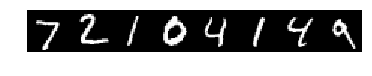

In [12]:
%%time
predictions = trained_model.predict(test_data)
imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28) for s in test_data.take(8)]),cmap='gray'); plt.axis('off')
print('Ground Truth labels:')
print(', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(8)))
print('Predicted labels:')
print(', '.join(str(map_predict_label(s)) for s in predictions.take(8)))